In [1]:
import os
import re
import math

import numpy as np
import pandas as pd
from scipy import stats
from scipy import spatial
from typing import Union, List
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import matplotlib.patches as patches

import MSDiversity as msd
# from voronoi import draw_voronoi_scatter
from tqdm import tqdm 

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198:

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

# Simulation Functions

In [21]:
def simulate_spatial_distribution(num_samples:int, 
                                  num_celltypes:int, 
                                  cells_per_type:Union[int, List[int]], 
                                  distribution_range: List[int], 
                                  clumped_cell_types=[0],
                                  num_clusters=10, 
                                  radius=150,
                                  seed=42): 
    np.random.seed(seed)  # Setting the seed
    dfs = []
    
    if clumped_cell_types is None:
        clumped_cell_types = []

    for sample_id in range(1, num_samples + 1):
        X, Y, cell_types = [], [], []
        cluster_centers = []
        
        for cell_type in range(num_celltypes):
            if cell_type in clumped_cell_types:
                # Clumped distribution for cell types in clumped_cell_types
                cells_per_cluster = cells_per_type[cell_type]//num_clusters
                for _ in range(num_clusters):
                    center_sd = 0
                    if radius > (distribution_range[cell_type][0] - distribution_range[cell_type][1])/2:
                        center_sd = 0.6*radius
                    x_center = np.random.uniform(distribution_range[cell_type][0]+center_sd, distribution_range[cell_type][1]-center_sd)
                    y_center = np.random.uniform(distribution_range[cell_type][0]+center_sd, distribution_range[cell_type][1]-center_sd)
                    for _ in range(cells_per_cluster):
                        valid = False
                        while not valid:
                            angle = 2 * np.pi * np.random.uniform(0, 1)  # Randomly choose an angle
                            #distance = np.random.uniform(0, radius)  # Randomly choose a distance
                            distance = np.sqrt(np.random.uniform(0, 1)) * radius
                            x = x_center + distance * np.cos(angle)
                            y = y_center + distance * np.sin(angle)
                            if distribution_range[cell_type][0] <= x <= distribution_range[cell_type][1] and distribution_range[cell_type][0] <= y <= distribution_range[cell_type][1]:
                                valid = True
                        X.append(x)
                        Y.append(y)
                    cluster_centers.append([x_center, y_center])
            else:
                # Uniform random distribution for other cell types
                for _ in range(cells_per_type[cell_type]):
                    too_close = True
                    while too_close:
                        X_temp = np.random.uniform(distribution_range[cell_type][0], distribution_range[cell_type][1])
                        Y_temp = np.random.uniform(distribution_range[cell_type][0], distribution_range[cell_type][1])
                        if cluster_centers:  # if there are points in clumped_points
                            distances = spatial.distance.cdist([[X_temp, Y_temp]], cluster_centers, 'euclidean')
                            too_close = np.any(distances < radius)
                        else:  # if there are no points in clumped_points
                            too_close = False
                    X.append(X_temp)
                    Y.append(Y_temp)
            cell_types.extend([cell_type] * cells_per_type[cell_type])

        # Creating a DataFrame to hold this sample's data
        sample_df = pd.DataFrame({
            'X': X,
            'Y': Y,
            'cell_type': cell_types,
            'sample': sample_id
        })

        # Appending the data to the list of dataframes
        dfs.append(sample_df)

    # Concatenating all dataframes
    protein = pd.concat(dfs)
    # Resetting the index
    protein.reset_index(drop=True, inplace=True)

    return protein

In [4]:
def simulate_self_similarity(num_samples:int, 
                             num_celltypes:int, 
                             cells_per_sample:Union[int, List[int]],
                             cell_type_proportions: List[float], 
                             grid_size:List[int], 
                             scale:int,
                             self_similar_degree=1.0,
                             cluster_degree=1.0,
                             clumped_cell_types=[0],
                             num_clusters=10, 
                             radius=150,
                             seed=42):
    np.random.seed(seed)
    dfs = []
    
    num_cell_types = len(cell_type_proportions)
    
    # Generate Patches
    patches = []
    patch_width = grid_size[0] / scale
    patch_height = grid_size[1] / scale
    
    for y0 in np.arange(0, grid_size[1], patch_height):
        for x0 in np.arange(0, grid_size[0], patch_width):
            # Define the coordinates of the current patch
            x1 = x0 + patch_width
            y1 = y0 + patch_height
            # Add the current patch to the list
            patches.append((x0, y0, x1, y1))

    if clumped_cell_types is None:
        clumped_cell_types = []
        
    # looping through each sample    
    for sample_id in range(1, num_samples + 1):
        dfs_sample =[]
        
        # Determine number of cells in each patch
        if isinstance(cells_per_sample, List):
            assert len(cells_per_sample) == num_samples, print(f'length of cells_per_sample is not eqaul to num_samples')
            cells_per_patch = cells_per_sample[sample_id-1] // scale**2
        else:
            cells_per_patch = cells_per_sample // scale**2
        print(f"Number of cells in each patch is {cells_per_patch}")
        
        for patch in patches:
            x0, y0, x1, y1 = patch
            X, Y, cell_types = [], [], []
            cluster_centers = []
            
            # Determine if cell_type_proportions will be distroted
            if np.random.rand() < (1 - self_similar_degree):
                noise = np.random.normal(0.5, 0.5, len(cell_type_proportions))  # Generate noise
                distorted_proportions = np.clip(cell_type_proportions + noise, 0, 1)
                distorted_proportions = distorted_proportions / np.sum(distorted_proportions)  # Normalize 
            else:
                distorted_proportions = cell_type_proportions
            print(distorted_proportions)
            for cell_type in range(num_celltypes):
                cells_per_type = int(cells_per_patch*distorted_proportions[cell_type])
                
                if cell_type in clumped_cell_types:
    
                    # Clumped distribution for cell types in clumped_cell_types
                    cells_per_cluster = cells_per_type // num_clusters
                
                    for _ in range(num_clusters):
                        if np.random.rand() < cluster_degree:  # Generate clumped cells
                            x_center = np.random.uniform(x0, x1)
                            y_center = np.random.uniform(y0, y1)
                            for _ in range(cells_per_cluster):
                                valid = False
                                while not valid:
                                    angle = 2 * np.pi * np.random.uniform(0, 1)  # Randomly choose an angle
                                    distance = np.sqrt(np.random.uniform(0, 1)) * radius
                                    x = x_center + distance * np.cos(angle)
                                    y = y_center + distance * np.sin(angle)
                                    if x0 <= x <= x1 and y0 <= y <= y1:
                                        valid = True
                                X.append(x)
                                Y.append(y)

                            cluster_centers.append([x_center, y_center])

                        else:  # Generate uniformly distributed cells for this cluster
                            for _ in range(cells_per_cluster):
                                X_temp = np.random.uniform(x0, x1)
                                Y_temp = np.random.uniform(y0, y1)
                                X.append(X_temp)
                                Y.append(Y_temp)
                else:
                    # Uniform random distribution for other cell types
                    for _ in range(cells_per_type):
                        too_close = True
                        while too_close:
                            X_temp = np.random.uniform(x0, x1)
                            Y_temp = np.random.uniform(y0, y1)
                            if cluster_centers:  # if there are points in clumped_points
                                distances = spatial.distance.cdist([[X_temp, Y_temp]], cluster_centers, 'euclidean')
                                too_close = np.any(distances < radius)
                            else:  # if there are no points in clumped_points
                                too_close = False
                        X.append(X_temp)
                        Y.append(Y_temp)
                cell_types.extend([cell_type] * cells_per_type)
            patch_df = pd.DataFrame({
                        'X': X,
                        'Y': Y,
                        'cell_type': cell_types,
                        'sample': sample_id
                    })
            dfs_sample.append(patch_df) 
        dfs.append(pd.concat(dfs_sample))
        
    # Concatenating all dataframes
    protein = pd.concat(dfs)
    # Resetting the index
    protein.reset_index(drop=True, inplace=True)

    return protein, patches

# Diveristy Dimension Self-Similar Simulation

In [ ]:
cell_types_proportions = [0.5,0.3,0.15,0.05]  # example proportions for three cell types
protein, patches_coordinates = simulate_self_similarity(num_samples=10, 
                                                       num_celltypes=len(cell_types_proportions), 
                                                       cells_per_sample=10000,
                                                       cell_type_proportions=cell_types_proportions, 
                                                       grid_size=[1600,1600], 
                                                       scale=8.,
                                                       self_similar_degree=0,
                                                       cluster_degree=1.0,
                                                       clumped_cell_types=[0],
                                                       num_clusters=4, 
                                                       radius=50,
                                                       seed=42)

# Non-Self-Similar simulation

In [58]:
# Illustration 1
# illustration_id = "1"
# library_id = 7
# num_celltypes = 8
# protein = simulate_spatial_distribution(num_samples=10, 
#                                         num_celltypes=num_celltypes, 
#                                         cells_per_type=[3600]+[1500]*(num_celltypes-1), 
#                                         distribution_range=[(0,800)]+[(0,800)]*(num_celltypes-1), 
#                                         clumped_cell_types=[],
#                                         num_clusters=1, 
#                                         radius=0)

# Illustration 2
# illustration_id = "2"
# library_id = 6
# num_celltypes = 8
# protein = simulate_spatial_distribution(num_samples=10, 
#                                         num_celltypes=num_celltypes, 
#                                         cells_per_type=[3600]+[1500]*(num_celltypes-1), 
#                                         distribution_range=[(0,800)]+[(0,800)]*(num_celltypes-1), 
#                                         clumped_cell_types=[0],
#                                         num_clusters=6, 
#                                         radius=70)


# Illustration 3
# illustration_id = "3"
# library_id = 7
# num_celltypes = 8
# protein = simulate_spatial_distribution(num_samples=10, 
#                                         num_celltypes=num_celltypes, 
#                                         cells_per_type=[3600]+[1500]*(num_celltypes-1), 
#                                         distribution_range=[(0,800)]+[(0,800)]*(num_celltypes-1), 
#                                         clumped_cell_types=[0],
#                                         num_clusters=1, 
#                                         radius=200)

# Illustration 4
illustration_id = "4"
library_id = 7
num_celltypes = 5
protein = simulate_spatial_distribution(num_samples=10, 
                                        num_celltypes=num_celltypes, 
                                        cells_per_type=[12900]+[300]*(num_celltypes-1), 
                                        distribution_range=[(0,800)]+[(0,800)]*(num_celltypes-1), 
                                        clumped_cell_types=[0],
                                        num_clusters=1, 
                                        radius=500)

# Plot Simulated Data

In [7]:
tulip = ['#F21D44','#F288AF','#72A603','#F2C48D','#FF9F18']
bokai_palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#000075','#46f0f0', 
                 '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#f032e6','#bcf60c',
                 '#800000', '#aaffc3', '#808000', '#ffd8b1', '#911eb4', '#808080', '#000000']

In [8]:
bokai_palette1 = dict(zip(pd.unique(protein['cell_type']), bokai_palette))

In [ ]:
fig, ax = plt.subplots()

# Create a scatter plot for each item in the dictionary
for label, color in bokai_palette1.items():
    ax.scatter([], [], c=color, label=label, marker='o',edgecolors=None, linewidths=0.5)

# Create the legend with a title
ax.legend(loc='center', ncol=2, fontsize='small', title='Cell_Type ID')

# Hide axes
ax.axis('off')

save_path = 'cellType' + '_legend.jpeg'
plt.savefig('../../MESA_figure1/'+save_path, dpi=300, bbox_inches='tight')
save_path = 'cellType' + '_legend.svg'
plt.savefig('../../MESA_figure1/'+save_path, dpi=300, bbox_inches='tight')
plt.show()

In [59]:
library_id = 6
protein_region = protein.loc[protein['sample'] == library_id,:]
patches_coordinates = msd.generate_patches(protein, 'sample', library_id, scaling_factor= 8., spatial_key=['X','Y'])

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_36530/2543679143.py:3: UserWarning: The palette list has more values (21) than needed (5), which may not be intended.
  sns.scatterplot(data=protein_region, x="X", y="Y", hue="cell_type", palette=bokai_palette, s=9, legend='full', rasterized=True,ax=axes)


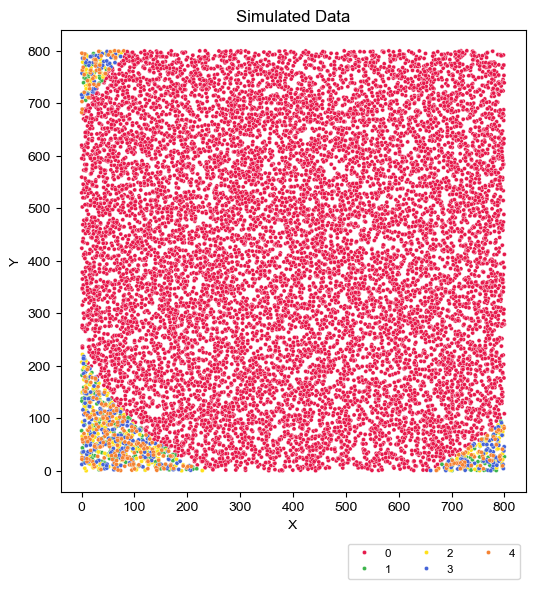

In [60]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

sns.scatterplot(data=protein_region, x="X", y="Y", hue="cell_type", palette=bokai_palette, s=9, legend='full', rasterized=True,ax=axes)
axes.set_title('Simulated Data')
axes.legend(bbox_to_anchor=(1.0, -0.1), ncol=3, fontsize='small')

plt.savefig("../../MESA_figure1/MDI_illustration"+illustration_id+".svg", dpi=300)
plt.show()

In [ ]:
_, fig = draw_voronoi_scatter(protein_region,
                         [],
                         voronoi_palette = sns.color_palette(tulip), 
                         X = 'X', 
                         Y = 'Y', 
                         voronoi_hue = 'cell_type',
                         voronoi_kwargs = {'edge_color':'white','line_width' : 0.31})
fig.savefig("./fig1.svg")

# Apply MESA on Simulated Data

In [25]:
# Define the sequence of scales
scales = [1., 2., 4., 8., 16., 32.]

In [26]:
# Define the library_ids
library_ids = [1,2,3,4,5,6,7,9,10]

In [61]:
df_results, df_slopes = msd.multiscale_diversity(spatial_data=protein,
                                                 scales=scales,
                                                 library_key='sample',
                                                 library_ids=library_ids,
                                                 spatial_key=['X','Y'],
                                                 cluster_key='cell_type',
                                                 random_patch=False,
                                                 plotfigs=False,
                                                 savefigs=False,
                                                 patch_kwargs={'random_seed': None, 'min_points':2},
                                                 other_kwargs={'metric': 'Shannon Diversity'})

Processing region: 1 at scale 1.0
0.000 per cent patches are empty
1 at scale 1.0 has 0 patches with zero diveristy
1 at scale 1.0 diversity is 0.5901338633331649
Processing region: 2 at scale 1.0
0.000 per cent patches are empty
2 at scale 1.0 has 0 patches with zero diveristy
2 at scale 1.0 diversity is 0.5897815822497127
Processing region: 3 at scale 1.0
0.000 per cent patches are empty
3 at scale 1.0 has 0 patches with zero diveristy
3 at scale 1.0 diversity is 0.5901338633331649
Processing region: 4 at scale 1.0
0.000 per cent patches are empty
4 at scale 1.0 has 0 patches with zero diveristy
4 at scale 1.0 diversity is 0.5901338633331649
Processing region: 5 at scale 1.0
0.000 per cent patches are empty
5 at scale 1.0 has 0 patches with zero diveristy
5 at scale 1.0 diversity is 0.5901338633331649
Processing region: 6 at scale 1.0
0.000 per cent patches are empty
6 at scale 1.0 has 0 patches with zero diveristy
6 at scale 1.0 diversity is 0.5901338633331649
Processing region: 7 a

In [62]:
print(df_results)
print('-'*42)
print(df_slopes)

            1         2         3         4         5         6         7   \
1.0   0.590134  0.589782  0.590134  0.590134  0.590134  0.590134  0.590134   
2.0   0.500887  0.486673  0.522528  0.503229   0.53246  0.512005  0.554751   
4.0   0.319742  0.293783  0.297518  0.367845   0.30813   0.30039  0.330519   
8.0   0.228171  0.207899  0.179346  0.278245   0.17546  0.189801  0.178266   
16.0  0.177636  0.161693  0.129347  0.215689  0.119567  0.141799  0.112957   
32.0  0.144278   0.12912   0.09771  0.177232  0.091103  0.114632  0.083051   

            9         10  
1.0   0.590134  0.590134  
2.0   0.498482  0.517104  
4.0   0.305466  0.295281  
8.0   0.216426  0.182927  
16.0  0.161898  0.132948  
32.0  0.131029  0.100746  
------------------------------------------
         1         2         3         4         5        6         7   \
0  0.094017  0.096118  0.107424  0.086192  0.110472  0.10282  0.114659   

         9        10  
0  0.096981  0.10605  


In [63]:
mean_values = df_results.mean(axis=1)
std_values = df_results.std(axis=1)

for mean, std in zip(mean_values, std_values):
    print(f"{mean:.4f}±{std:.4f}")


0.5901±0.0001
0.5142±0.0205
0.3132±0.0238
0.2041±0.0335
0.1504±0.0325
0.1188±0.0299


In [64]:
mean_values = df_slopes.mean(axis=1)
std_values = df_slopes.std(axis=1)

for mean, std in zip(mean_values, std_values):
    print(f"{mean:.3f}±{std:.3f}")


0.102±0.009


In [65]:
total_comp_dict, morans_results, _ = msd.diversity_clustering(spatial_data=protein, 
                                                              scale=32.0, 
                                                              library_key='sample',
                                                              library_ids=library_ids, 
                                                              spatial_key=['X','Y'],
                                                              cluster_key='cell_type',
                                                              hotspot=True,
                                                              metric='Shannon Diversity')

Processing region: 1 at scale 32.0
0.000 per cent patches are empty
Region 1 contains 78 diversity hotspots
Considering only hotspots
Processing region: 2 at scale 32.0
0.000 per cent patches are empty
Region 2 contains 68 diversity hotspots
Considering only hotspots
Processing region: 3 at scale 32.0
0.000 per cent patches are empty
Region 3 contains 48 diversity hotspots
Considering only hotspots
Processing region: 4 at scale 32.0
0.000 per cent patches are empty
Region 4 contains 95 diversity hotspots
Considering only hotspots
Processing region: 5 at scale 32.0
0.000 per cent patches are empty
Region 5 contains 43 diversity hotspots
Considering only hotspots
Processing region: 6 at scale 32.0
0.000 per cent patches are empty
Region 6 contains 60 diversity hotspots
Considering only hotspots
Processing region: 7 at scale 32.0
0.000 per cent patches are empty
Region 7 contains 41 diversity hotspots
Considering only hotspots
Processing region: 9 at scale 32.0
0.000 per cent patches are 

In [66]:
morans = np.array([v[0] for k, v in morans_results.items()])

In [67]:
print(f"{morans.mean():.3f}±{morans.std():.3f}")

0.796±0.027


In [68]:
proximity_I = msd.sample_proximity(spatial_data=protein, 
                                       scale=32.0, 
                                       library_key='sample',
                                       library_ids=library_ids, 
                                       spatial_key=['X', 'Y'],
                                       cluster_key='cell_type',
                                       hotspot=True,
                                       metric='Shannon Diversity')



Processing region: 1 at scale 32.0
0.000 per cent patches are empty
Region 1 contains 78 diversity hotspots
2 islands identified
Processing region: 2 at scale 32.0
0.000 per cent patches are empty
Region 2 contains 68 diversity hotspots
2 islands identified
Processing region: 3 at scale 32.0
0.000 per cent patches are empty
Region 3 contains 48 diversity hotspots
3 islands identified
Processing region: 4 at scale 32.0
0.000 per cent patches are empty
Region 4 contains 95 diversity hotspots
3 islands identified
Processing region: 5 at scale 32.0
0.000 per cent patches are empty
Region 5 contains 43 diversity hotspots
3 islands identified
Processing region: 6 at scale 32.0
0.000 per cent patches are empty
Region 6 contains 60 diversity hotspots
3 islands identified
Processing region: 7 at scale 32.0
0.000 per cent patches are empty
Region 7 contains 41 diversity hotspots
4 islands identified
Processing region: 9 at scale 32.0
0.000 per cent patches are empty
Region 9 contains 67 diversit

In [69]:
DPIs = np.array([v[0] for k, v in proximity_I.items()])
print(f"{DPIs.mean():.3f}±{DPIs.std():.3f}")

3.763±2.072


# Plot Trends

In [18]:
number_of_clusters = [1,2,4,8]
slope_m = [0.0922, 0.1073, 0.1194, 0.1348]
slope_sd = [0.0018, 0.0047, 0.0029, 0.0036]

moran_m = [0.4648, 0.5500, 0.5747, 0.5782]
moran_sd = [0.0253, 0.0312, 0.0246, 0.0319]

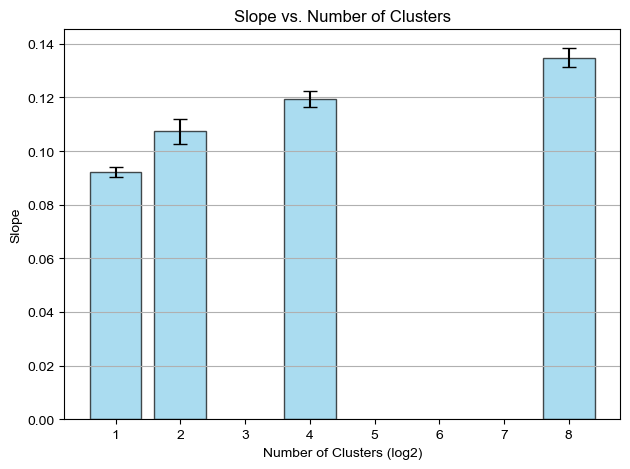

In [19]:
# Plotting
plt.bar(number_of_clusters, slope_m, yerr=slope_sd, capsize=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Clusters (log2)')
plt.ylabel('Slope')
plt.title('Slope vs. Number of Clusters')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

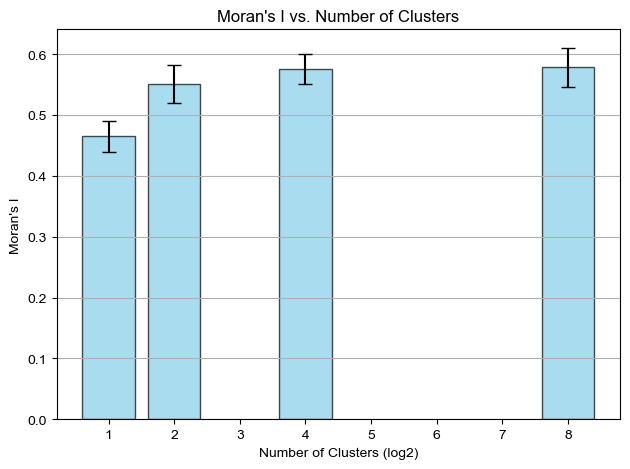

In [20]:
# Plotting
plt.bar(number_of_clusters, moran_m, yerr=moran_sd, capsize=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Clusters (log2)')
plt.ylabel("Moran's I")
plt.title("Moran's I vs. Number of Clusters")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [80]:
size_of_clusters = np.log2([100,200,400,800])
slope_m = [0.0922, 0.1124, 0.1694, 0.3605]
slope_sd = [0.0018, 0.0062, 0.0249, 0.0611]

moran_m = [0.4648, 0.7333, 0.8925, 0.9309]
moran_sd = [0.0253, 0.0096, 0.0145, 0.0214]

moran_slope_m = [-0.2121, -0.2890, -0.3263, -0.3009]
moran_slope_sd = [0.0090, 0.0122, 0.0076, 0.0086]

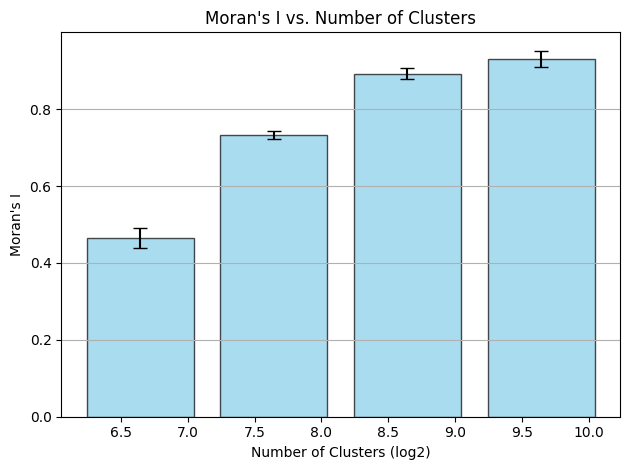

In [81]:
# Plotting
plt.bar(size_of_clusters, moran_m, yerr=moran_sd, capsize=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Clusters (log2)')
plt.ylabel("Moran's I")
plt.title("Moran's I vs. Number of Clusters")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

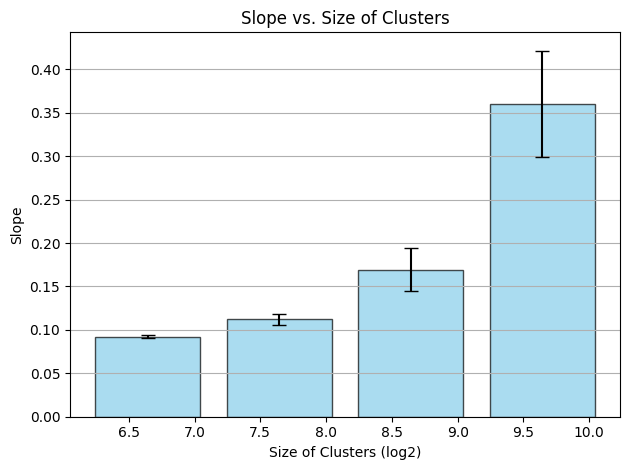

In [82]:
# Plotting
plt.bar(size_of_clusters, slope_m, yerr=slope_sd, capsize=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Size of Clusters (log2)')
plt.ylabel('Slope')
plt.title('Slope vs. Size of Clusters')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()